In [143]:
# MySQL
import psycopg2
import mysql.connector
# Numpy and Dataframe
import numpy as np
import pandas as pd
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [119]:
# Connect database
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="password"
)
mycursor = mydb.cursor()

In [120]:
# Extract dataset
mycursor.execute(
    "SELECT date, brand, price\
    FROM base.WA_fuel\
    WHERE (fuel = 'ULP') AND (postcode = 6000)"
)

result = mycursor.fetchall()

In [121]:
for x in result:
    print(x)

('01/01/2019', 'Caltex', 139.7)
('01/01/2019', 'Caltex', 139.7)
('01/01/2019', 'Caltex', 139.7)
('01/01/2019', 'Coles Express', 142.9)
('01/01/2019', 'Liberty', 132.4)
('02/01/2019', 'Caltex', 136.7)
('02/01/2019', 'Caltex', 136.7)
('02/01/2019', 'Caltex', 136.7)
('02/01/2019', 'Coles Express', 140.9)
('02/01/2019', 'Liberty', 132.4)
('03/01/2019', 'Caltex', 133.9)
('03/01/2019', 'Caltex', 133.9)
('03/01/2019', 'Caltex', 134.3)
('03/01/2019', 'Coles Express', 138.9)
('03/01/2019', 'Liberty', 132.4)
('04/01/2019', 'Caltex', 131.9)
('04/01/2019', 'Caltex', 131.9)
('04/01/2019', 'Caltex', 131.9)
('04/01/2019', 'Coles Express', 136.9)
('04/01/2019', 'Liberty', 132.4)
('05/01/2019', 'Caltex', 125.5)
('05/01/2019', 'Caltex', 125.5)
('05/01/2019', 'Caltex', 125.5)
('05/01/2019', 'Coles Express', 132.9)
('05/01/2019', 'Liberty', 132.4)
('06/01/2019', 'Caltex', 123.5)
('06/01/2019', 'Caltex', 123.5)
('06/01/2019', 'Caltex', 119.5)
('06/01/2019', 'Coles Express', 129.9)
('06/01/2019', 'Liberty',

In [122]:
# Turn SQL result into dataframe
df = pd.DataFrame(result, columns=['date','brand','price'])
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
df.head(10)

Number of rows: 8055
Number of columns: 3


,date,brand,price
0,01/01/2019,Caltex,139.7
1,01/01/2019,Caltex,139.7
2,01/01/2019,Caltex,139.7
3,01/01/2019,Coles Express,142.9
4,01/01/2019,Liberty,132.4
5,02/01/2019,Caltex,136.7
6,02/01/2019,Caltex,136.7
7,02/01/2019,Caltex,136.7
8,02/01/2019,Coles Express,140.9
9,02/01/2019,Liberty,132.4


In [123]:
df.drop_duplicates(inplace=True)
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
df.reset_index(drop=True, inplace=True)
df.head(10)

Number of rows: 7028
Number of columns: 3


,date,brand,price
0,01/01/2019,Caltex,139.7
1,01/01/2019,Coles Express,142.9
2,01/01/2019,Liberty,132.4
3,02/01/2019,Caltex,136.7
4,02/01/2019,Coles Express,140.9
5,02/01/2019,Liberty,132.4
6,03/01/2019,Caltex,133.9
7,03/01/2019,Caltex,134.3
8,03/01/2019,Coles Express,138.9
9,03/01/2019,Liberty,132.4


In [125]:
# Convert date column into datetime
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

In [126]:
df.head()

,date,brand,price
0,2019-01-01,Caltex,139.7
1,2019-01-01,Coles Express,142.9
2,2019-01-01,Liberty,132.4
3,2019-01-02,Caltex,136.7
4,2019-01-02,Coles Express,140.9


In [127]:
# Congregate data using months
df['month_year'] = df['date'].dt.to_period('M')
df['date'] = df['month_year']

In [128]:
# Group dataset by date and aggregate by price's mean
df_uni = df.groupby(['date'])['price'].agg('mean')

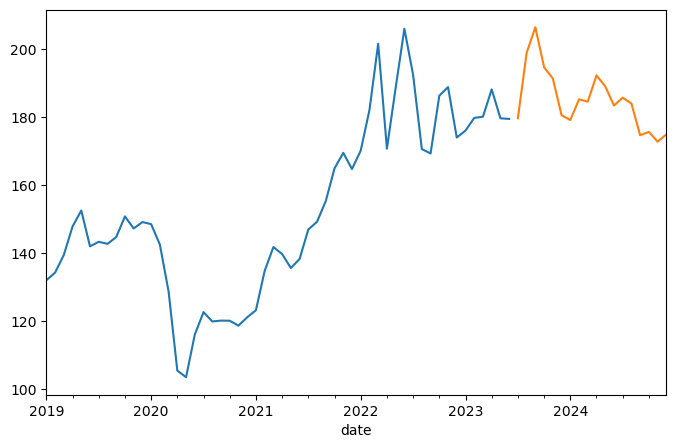

In [135]:
# Training and testing datasets
train = df_uni.iloc[:round(.75*len(df_uni))]
test = df_uni.iloc[round(.75*len(df_uni)):]
fig, ax = plt.subplots(figsize=(8,5))
train.plot(ax=ax)
test.plot(ax=ax)
plt.show()

In [138]:
# Testing trend stationarity
from statsmodels.tsa.stattools import adfuller
adfuller(df_uni)

(-1.192307768997332,
 0.6768959312095227,
 2,
 69,
 {'1%': -3.528889992207215,
  '5%': -2.9044395987933362,
  '10%': -2.589655654274312},
 437.1916843762741)

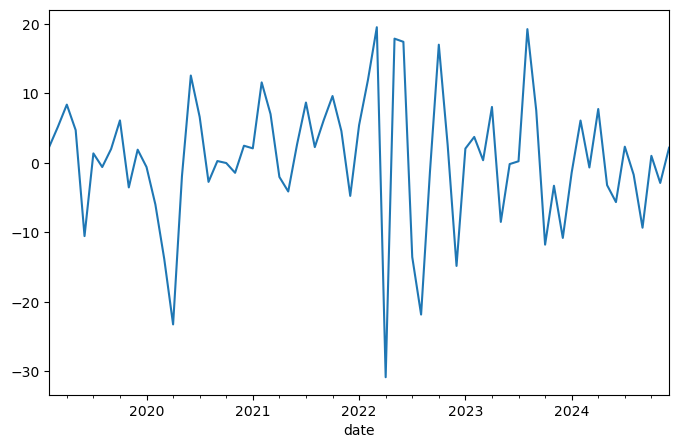

(-8.13817804927637,
 1.0454108109952387e-12,
 1,
 69,
 {'1%': -3.528889992207215,
  '5%': -2.9044395987933362,
  '10%': -2.589655654274312},
 429.60848066331334)

In [142]:
# Take first difference and test again
df_uni_1diff = df_uni.diff(1).dropna()

fig, ax = plt.subplots(figsize=(8,5))
df_uni_1diff.plot(ax=ax)
plt.show()

adfuller(df_uni_1diff)

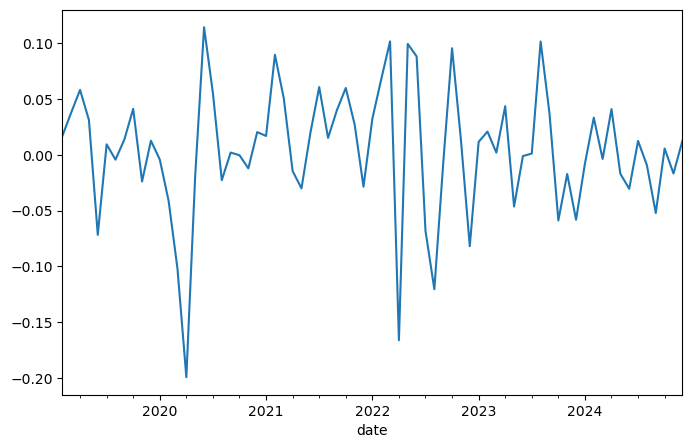

(-7.645857467271788,
 1.8435323311266343e-11,
 1,
 69,
 {'1%': -3.528889992207215,
  '5%': -2.9044395987933362,
  '10%': -2.589655654274312},
 -161.87835491871454)

In [145]:
# Try log-return and test again
df_uni_logreturn = np.log(df_uni/df_uni.shift(1)).dropna()

fig, ax = plt.subplots(figsize=(8,5))
df_uni_logreturn.plot(ax=ax)
plt.show()

adfuller(df_uni_logreturn)

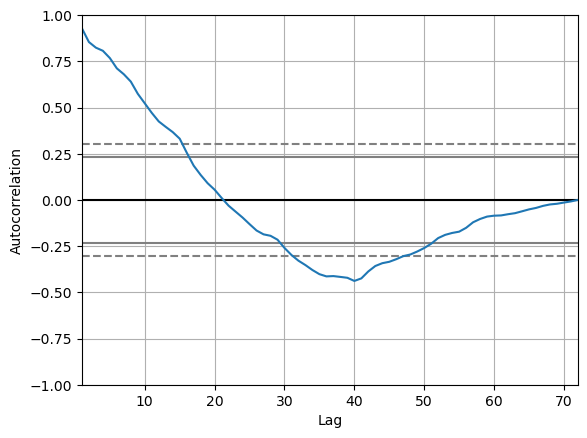

In [136]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_uni)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                   72
Model:                ARIMA(10, 0, 0)   Log Likelihood                -256.021
Date:                Mon, 23 Dec 2024   AIC                            536.041
Time:                        20:25:18   BIC                            563.361
Sample:                    01-31-2019   HQIC                           546.918
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        157.6795     19.652      8.024      0.000     119.163     196.196
ar.L1          1.0180      0.080     12.754      0.000       0.862       1.174
ar.L2         -0.3215      0.157     -2.053      0.0

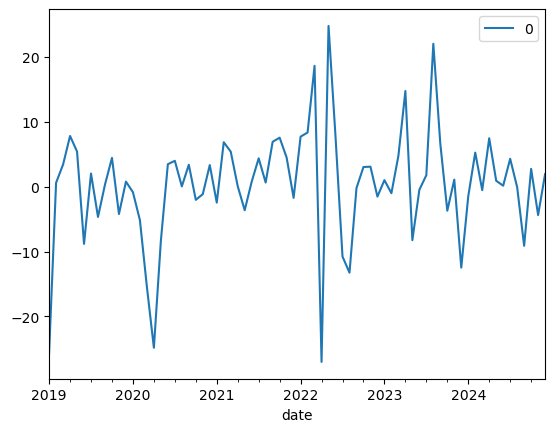

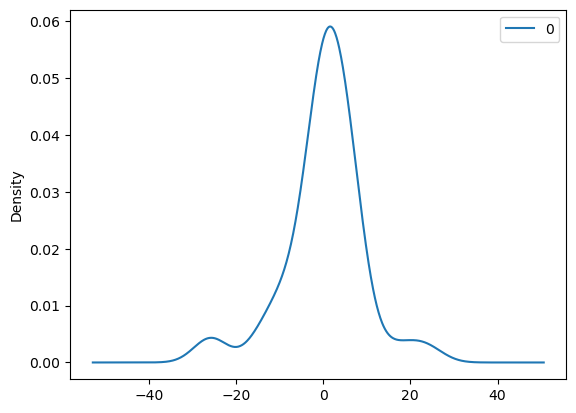

               0
count  72.000000
mean    0.274352
std     8.849858
min   -26.999186
25%    -2.150833
50%     0.759056
75%     4.433959
max    24.736894


In [116]:
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(df_uni, order=(10,0,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())